In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 5.9MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 12.8MB 209kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 296kB 5.3MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-10 08:28:17--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-10 08:28:17--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc370afb9bef9fdd13849ee288e8.dl.dropboxusercontent.com/cd/0/get/BKYCgroI1OMt7HQ2FMyoL-Xp7YzEEDqtJSQaO8uLZIxJn4QqJ7qHNipoZlCil6D-7oLgywE7aHOA1ztMr-5DFryJhv26PfsDlYuSRueZDutG8E_czql4CVCqs9wotCYFaZa76PS4Vgo4J21VBZegxdh7/file?dl=1# [following]
--2021-03-10 08:28:18--  https://uc370afb9bef9fdd13849ee288e8.dl.dropboxusercontent.com/cd/0/get/BKYCgroI1OMt7HQ2FMyoL-Xp7YzEEDqtJSQaO8uLZIxJn4QqJ7qHNipoZlCil

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
import timm
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo=timm.models.hrnet.hrnet_w40(num_classes=2)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-hrnet/hrnetv2_w40-7cd397a4.pth" to /root/.cache/torch/hub/checkpoints/hrnetv2_w40-7cd397a4.pth


In [10]:
lr=1e-4

## Ranger

In [11]:
opt_func = partial(ranger, beta=0.99, eps=1e-6)

In [12]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.6309573650360107)

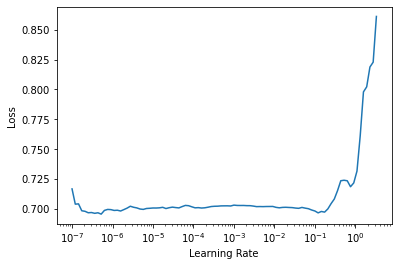

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.696564,0.693031,0.518349,0.533175,0.655977,04:38
1,0.698147,0.693063,0.515290,0.535326,0.574344,04:37


Better model found at epoch 0 with valid_loss value: 0.6930312514305115.


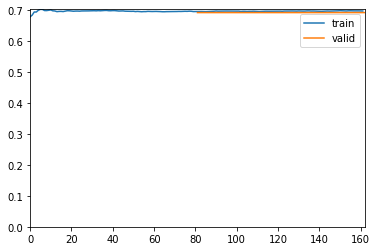

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.700242,0.692430,0.525994,0.539379,0.658892,04:36
1,0.701721,0.692735,0.515290,0.531863,0.632653,04:37
2,0.698675,0.692446,0.516820,0.534005,0.618076,04:37
3,0.697273,0.692327,0.516820,0.536585,0.577259,04:36
4,0.696440,0.692485,0.516820,0.536388,0.580175,04:36
5,0.698559,0.692476,0.521407,0.546296,0.516035,04:37
6,0.697564,0.692599,0.519878,0.545171,0.510204,04:38


Better model found at epoch 0 with valid_loss value: 0.6924300193786621.


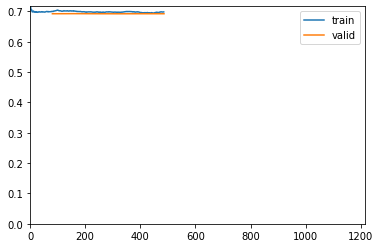

Better model found at epoch 3 with valid_loss value: 0.692326545715332.
No improvement since epoch 3: early stopping


In [14]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

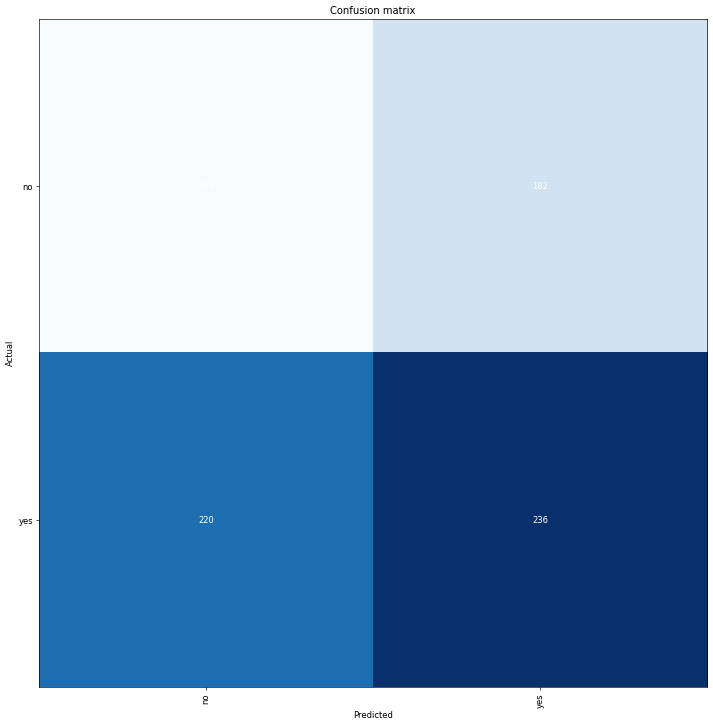

In [16]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [17]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5018587112426758.


(#4) [0.6977640390396118,0.5018587112426758,0.5645933014354066,0.5175438596491229]

## Faltten

In [18]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.714817,0.705260,0.464832,0.266667,0.011662,04:33
1,0.705762,0.695320,0.477064,0.571429,0.011662,04:33


Better model found at epoch 0 with valid_loss value: 0.7052599191665649.


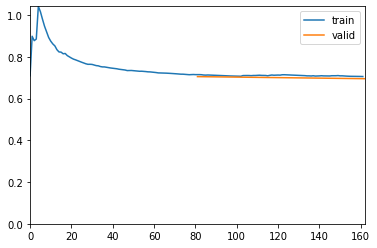

Better model found at epoch 1 with valid_loss value: 0.6953195929527283.


In [19]:
learn.fit_flat_cos(2,lr=1e-3)

In [20]:
learn.unfreeze()

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=0.14454397559165955)

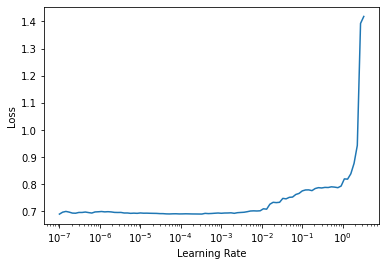

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.696290,0.693279,0.501529,0.528428,0.460641,04:33
1,0.695696,0.694623,0.487768,0.515267,0.393586,04:33
2,0.695807,0.694336,0.506116,0.525253,0.606414,04:33
3,0.692844,0.688958,0.553517,0.560284,0.690962,04:33
4,0.691069,0.698677,0.480122,0.800000,0.011662,04:32
5,0.687119,0.677327,0.570336,0.583784,0.629738,04:33
6,0.671743,0.652436,0.617737,0.624665,0.679300,04:32
7,0.661699,0.645030,0.626911,0.632708,0.688047,04:34
8,0.628510,0.629487,0.634557,0.734234,0.475219,04:35
9,0.611127,0.625143,0.626911,0.730233,0.457726,04:35


Better model found at epoch 0 with valid_loss value: 0.6932786703109741.


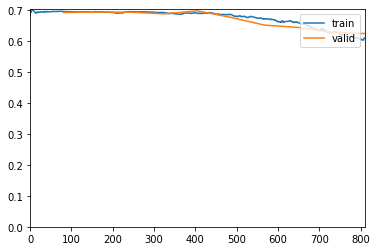

Better model found at epoch 3 with valid_loss value: 0.6889576315879822.
Better model found at epoch 5 with valid_loss value: 0.6773274540901184.
Better model found at epoch 6 with valid_loss value: 0.6524361968040466.
Better model found at epoch 7 with valid_loss value: 0.6450300812721252.
Better model found at epoch 8 with valid_loss value: 0.6294870376586914.
Better model found at epoch 9 with valid_loss value: 0.6251433491706848.


In [22]:
learn.fit_flat_cos(10,lr=1e-4)

In [23]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

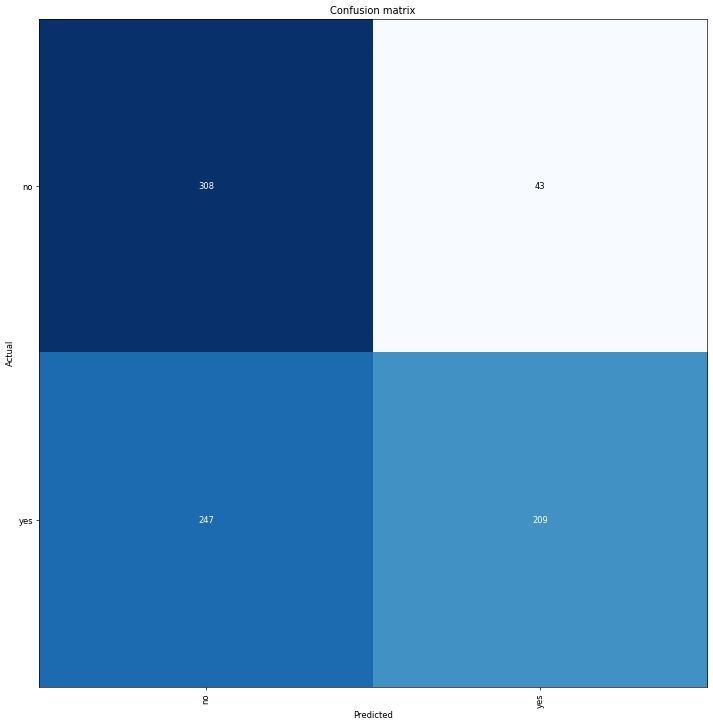

In [24]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [25]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.640644371509552.


(#4) [0.6231653094291687,0.640644371509552,0.8293650793650794,0.4583333333333333]

## LabelSmoothing

In [26]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.311311274956097e-06)

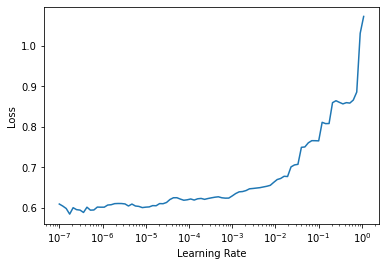

In [27]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.620690,0.639099,0.646789,0.722222,0.530612,04:34
1,0.621273,0.638385,0.643731,0.676282,0.615160,04:35


Better model found at epoch 0 with valid_loss value: 0.6390994191169739.


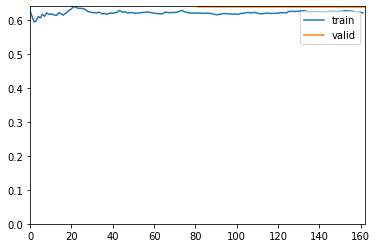

Better model found at epoch 1 with valid_loss value: 0.6383852958679199.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.616302,0.635048,0.652905,0.718045,0.556851,04:36
1,0.607514,0.623573,0.669725,0.697819,0.653061,04:35
2,0.601251,0.634935,0.651376,0.696246,0.594752,04:33
3,0.604709,0.639741,0.633027,0.710204,0.507289,04:34
4,0.599429,0.638543,0.648318,0.755656,0.486880,04:36


Better model found at epoch 0 with valid_loss value: 0.6350477933883667.


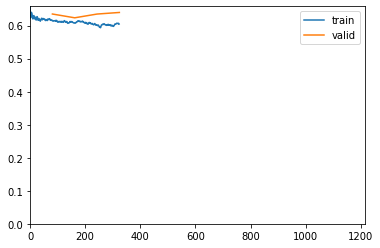

Better model found at epoch 1 with valid_loss value: 0.6235725283622742.
No improvement since epoch 1: early stopping


In [28]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [29]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

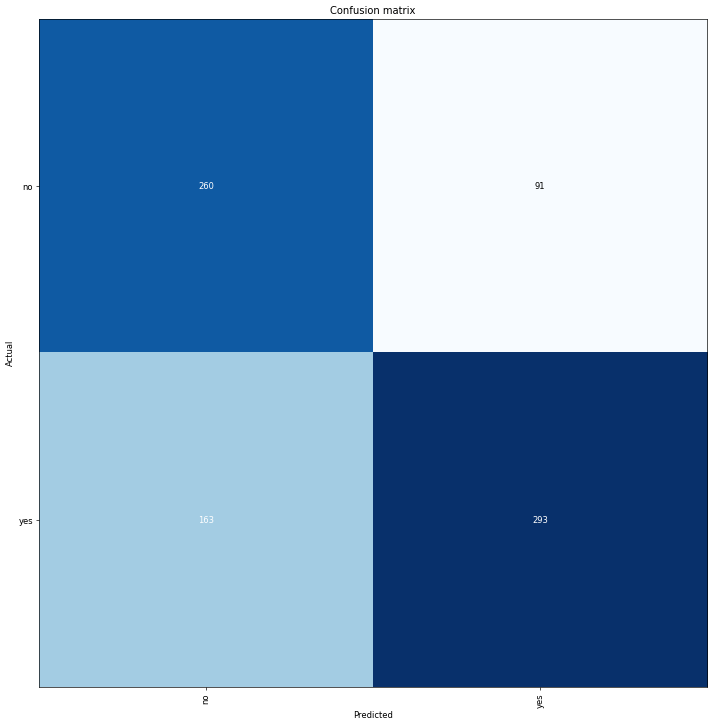

In [30]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [31]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6852540373802185.


(#4) [0.5995798110961914,0.6852540373802185,0.7630208333333334,0.6425438596491229]

## MixUp

In [32]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [33]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.623408,0.602539,0.683486,0.698830,0.696793,04:35
1,0.630055,0.666346,0.593272,0.808000,0.294461,04:35


Better model found at epoch 0 with valid_loss value: 0.6025391817092896.


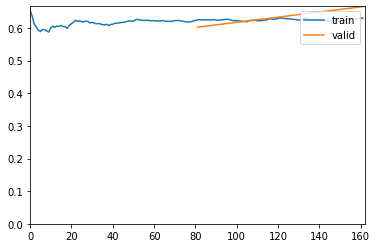

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.606006,0.602276,0.674312,0.712418,0.635569,04:33
1,0.614134,0.603387,0.688073,0.699140,0.711370,04:33
2,0.611602,0.604855,0.689602,0.741379,0.626822,04:33
3,0.607735,0.607580,0.674312,0.667526,0.755102,04:33


Better model found at epoch 0 with valid_loss value: 0.6022756099700928.


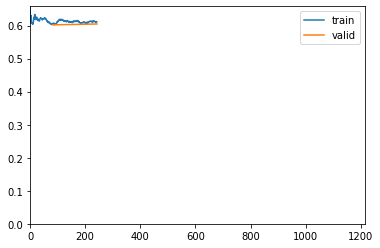

No improvement since epoch 0: early stopping


In [34]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [35]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

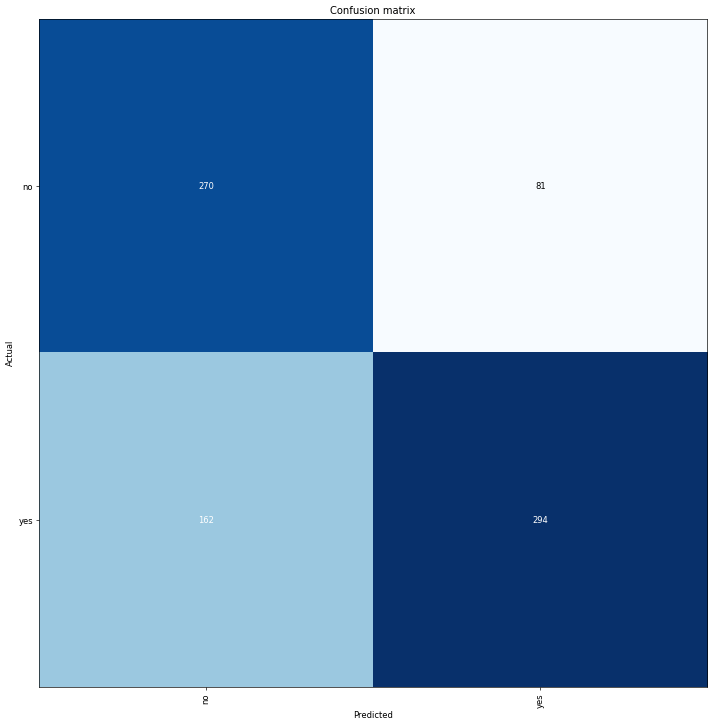

In [36]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [37]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6988847851753235.


(#4) [0.5692400932312012,0.6988847851753235,0.784,0.6447368421052632]

## Ranger + Flat cosin Anneal

In [38]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.569428,0.600289,0.674312,0.709677,0.641399,04:35
1,0.574749,0.598753,0.672783,0.703470,0.650146,04:36


Better model found at epoch 0 with valid_loss value: 0.6002888083457947.


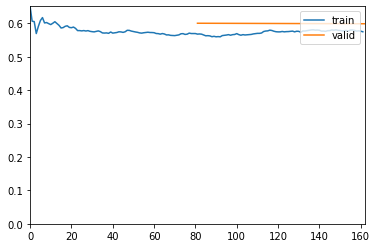

Better model found at epoch 1 with valid_loss value: 0.5987529158592224.


In [39]:
learn.fit_flat_cos(2,lr=1e-3)

In [40]:
learn.unfreeze()

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=5.754399353463668e-06)

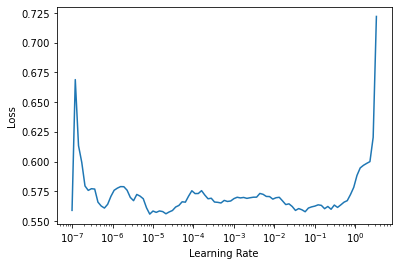

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.563623,0.602399,0.668196,0.700637,0.641399,04:35
1,0.575431,0.599692,0.672783,0.698462,0.661808,04:35


Better model found at epoch 0 with valid_loss value: 0.6023985147476196.


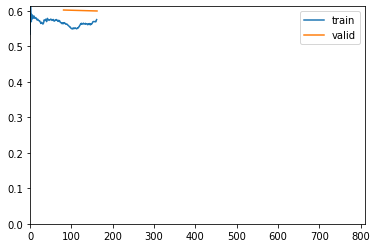

Better model found at epoch 1 with valid_loss value: 0.5996915698051453.


In [ ]:
learn.fit_flat_cos(10,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(15,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Ranger +Flat + Label + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(15,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.validate()

## Ranger + Flat + MixUp

In [ ]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(15,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Ranger + MixUp

In [ ]:
#opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

In [ ]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Faltten + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(10,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Ranger + Label

In [ ]:
#opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Faltten + Label

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fit_flat_cos(2,lr=1e-3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10,lr=1e-4)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

## Label + MixUp

In [ ]:
learn = Learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.fine_tune(15,freeze_epochs=2,base_lr=lr)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()